### Description
In this notebook, we will see a comprehensive overview of some common tasks that anyone would be implementing in VectorBT Pro. We will be using the [`Double Bollinger Band Strategy`](https://abouttrading.substack.com/p/the-double-bollinger-trading-strategy) as an example of a Multi-Time Frame Strategy to accomplish the following objectives:
* `Resampling` lowertime frame (1m) data to higher time frame data
* Constructing the strategy rules, which uses two different timeframes for the entry and exit conditions
* Visualize the indicators and entry/exit signals on VBT Plots
* Run the backtesting simulation using `from_signals`
* Visualize and discuss the simulation results

In [1]:
import pandas as pd
import numpy as np
import vectorbtpro as vbt

In [2]:
## Load m1 data
m1_data = vbt.HDFData.fetch('../../data/GU_OHLCV_3Y.h5')
m1_data.wrapper.index #pandas doaesn't recognise the frequency because of missing timestamps

DatetimeIndex(['2019-08-27 00:00:00+00:00', '2019-08-27 00:01:00+00:00',
               '2019-08-27 00:02:00+00:00', '2019-08-27 00:03:00+00:00',
               '2019-08-27 00:04:00+00:00', '2019-08-27 00:05:00+00:00',
               '2019-08-27 00:06:00+00:00', '2019-08-27 00:07:00+00:00',
               '2019-08-27 00:08:00+00:00', '2019-08-27 00:09:00+00:00',
               ...
               '2022-08-26 16:50:00+00:00', '2022-08-26 16:51:00+00:00',
               '2022-08-26 16:52:00+00:00', '2022-08-26 16:53:00+00:00',
               '2022-08-26 16:54:00+00:00', '2022-08-26 16:55:00+00:00',
               '2022-08-26 16:56:00+00:00', '2022-08-26 16:57:00+00:00',
               '2022-08-26 16:58:00+00:00', '2022-08-26 16:59:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=1122468, freq=None)

Downsampling `1 minute` data to Higher Time Frames

In [3]:
m5_data = m1_data.resample('5T')   # Convert 1 minute to 5 mins
m15_data = m1_data.resample('15T') # Convert 1 minute to 15 mins
m30_data = m1_data.resample('30T') # Convert 1 minute to 30 mins
h1_data = m1_data.resample("1h")   # Convert 1 minute to 1 hour
h4_data = m1_data.resample("4h")   # Convert 1 minute to 4 hour
d1_data = m1_data.resample("1d")   # Convert 1 minute to daily

Check missing frequency on the resampled higher timeframe data.
- The missing frequency has been checked for ` freq = '4H'` `  

In [4]:
h4_data.wrapper.index

DatetimeIndex(['2019-08-27 00:00:00+00:00', '2019-08-27 04:00:00+00:00',
               '2019-08-27 08:00:00+00:00', '2019-08-27 12:00:00+00:00',
               '2019-08-27 16:00:00+00:00', '2019-08-27 20:00:00+00:00',
               '2019-08-28 00:00:00+00:00', '2019-08-28 04:00:00+00:00',
               '2019-08-28 08:00:00+00:00', '2019-08-28 12:00:00+00:00',
               ...
               '2022-08-25 04:00:00+00:00', '2022-08-25 08:00:00+00:00',
               '2022-08-25 12:00:00+00:00', '2022-08-25 16:00:00+00:00',
               '2022-08-25 20:00:00+00:00', '2022-08-26 00:00:00+00:00',
               '2022-08-26 04:00:00+00:00', '2022-08-26 08:00:00+00:00',
               '2022-08-26 12:00:00+00:00', '2022-08-26 16:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=6575, freq='4H')

In [5]:
# Obtain all the closing  prices using the .get() method
m5_close = m5_data.get()['Close']
m30_close = m30_data.get()['Close']

## h1 data
h1_open =  h1_data.get()['Open']
h1_close = h1_data.get()['Close']
h1_high =  h1_data.get()['High']
h1_low =  h1_data.get()['Low']

## h4 data
h4_open  = h4_data.get()['Open']
h4_close  = h4_data.get()['Close']
h4_high  = h4_data.get()['High']
h4_low  = h4_data.get()['Low']

In [6]:
## Check for a sample of missing time periods during weelemds
## Looks like a typical closure during weekends, on Friday evening (30.08.2019) and reopening at Tokyo market open
# m30_close[(m30_close.index > "2019-08-29") & (m30_close.index < "2019-09-02")]
h4_close[(h4_close.index > "2019-08-29") & (h4_close.index < "2019-09-02")]#.dropna()

time
2019-08-29 04:00:00+00:00    1.221835
2019-08-29 08:00:00+00:00    1.219570
2019-08-29 12:00:00+00:00    1.218045
2019-08-29 16:00:00+00:00    1.218370
2019-08-29 20:00:00+00:00    1.217570
2019-08-30 00:00:00+00:00    1.217655
2019-08-30 04:00:00+00:00    1.218535
2019-08-30 08:00:00+00:00    1.216520
2019-08-30 12:00:00+00:00    1.216930
2019-08-30 16:00:00+00:00    1.216260
2019-08-30 20:00:00+00:00         NaN
2019-08-31 00:00:00+00:00         NaN
2019-08-31 04:00:00+00:00         NaN
2019-08-31 08:00:00+00:00         NaN
2019-08-31 12:00:00+00:00         NaN
2019-08-31 16:00:00+00:00         NaN
2019-08-31 20:00:00+00:00         NaN
2019-09-01 00:00:00+00:00         NaN
2019-09-01 04:00:00+00:00         NaN
2019-09-01 08:00:00+00:00         NaN
2019-09-01 12:00:00+00:00         NaN
2019-09-01 16:00:00+00:00    1.215845
2019-09-01 20:00:00+00:00    1.216015
Freq: 4H, Name: Close, dtype: float64

In [7]:
h4_close.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 6575 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:00:00+00:00
Freq: 4H
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
4841 non-null   float64
dtypes: float64(1)
memory usage: 102.7 KB


### Create Indicators for multiple timeframes

This _Double Bollinger Band_ strategy assumes a double confirmation factor from two types of Bollinger bands. Basically, to create the strategy, you need to do the following:
* Calculate a 20-period RSI on the market price.
* Calculate a 20-period Bollinger bands (with 2x standard deviation) on the market price.
* Calculate a 20-period Bollinger bands (with 2x standard deviation) on the RSI.

**TODO** :
* Find out what the `.real` does?

In [8]:
rsi_period = 21

m5_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m5_data.get("Close"), skipna=True).real
m5_bbands = vbt.talib("BBANDS").run(m5_data.get("Close"), skipna=True)
m5_bbands_rsi = vbt.talib("BBANDS").run(m5_rsi, skipna=True)

m30_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m30_data.get("Close"), skipna=True).real
m30_bbands = vbt.talib("BBANDS").run(m30_data.get("Close"), skipna=True)
m30_bbands_rsi = vbt.talib("BBANDS").run(m30_rsi, skipna=True)

h1_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h1_data.get("Close"), skipna=True).real
h1_bbands = vbt.talib("BBANDS").run(h1_data.get("Close"), skipna=True)
h1_bbands_rsi = vbt.talib("BBANDS").run(h1_rsi, skipna=True)

h4_rsi = vbt.talib("RSI", timeperiod = rsi_period).run(h4_data.get("Close"), skipna=True).real
h4_bbands = vbt.talib("BBANDS").run(h4_data.get("Close"), skipna=True)
h4_bbands_rsi = vbt.talib("BBANDS").run(h4_rsi, skipna=True)

In [9]:
## Alternate fancier method 2 of constructing BBAnd data for MTF data
rsi = vbt.talib("RSI", timeperiod = rsi_period).run(m5_close, skipna=True,
                                                   timeframe=["5T","30T","1h","4h"],
                                                   broadcast_kwargs=dict(wrapper_kwargs=dict(freq="5T"))).real
                                                   
bbands_price = vbt.talib("BBANDS").run(m5_close, skipna=True, 
                                timeframe=["5T","30T","1h","4h"], 
                                broadcast_kwargs=dict(wrapper_kwargs=dict(freq="5T")))


bbands_rsi = vbt.talib("BBANDS").run(m5_rsi, skipna=True, 
                                timeframe=["5T","30T","1h","4h"], 
                                broadcast_kwargs=dict(wrapper_kwargs=dict(freq="5T")))

In [10]:
m5_bbands.lowerband.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 315564 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:55:00+00:00
Freq: 5T
Series name: Close
Non-Null Count   Dtype  
--------------   -----  
224775 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [11]:
bbands_price['5T'].lowerband.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 315564 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:55:00+00:00
Freq: 5T
Series name: 5T
Non-Null Count   Dtype  
--------------   -----  
315560 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [12]:
## Extracting the bbands_data
pd.DataFrame(data = {"5m_bb_price_lower" : bbands_price["5T"].lowerband,
                     "5m_bb_price_middle" : bbands_price["5T"].middleband,
                     "5m_bb_price_higher": bbands_price["5T"].upperband})


,5m_bb_price_lower,5m_bb_price_middle,5m_bb_price_higher
time,,,
2019-08-27 00:00:00+00:00,NaN,NaN,NaN
2019-08-27 00:05:00+00:00,NaN,NaN,NaN
2019-08-27 00:10:00+00:00,NaN,NaN,NaN
2019-08-27 00:15:00+00:00,NaN,NaN,NaN
2019-08-27 00:20:00+00:00,1.220975,1.221297,1.221619
...,...,...,...
2022-08-26 16:35:00+00:00,1.173426,1.173867,1.174308
2022-08-26 16:40:00+00:00,1.173739,1.173954,1.174169
2022-08-26 16:45:00+00:00,1.173717,1.173929,1.174141


In [13]:
pd.DataFrame(data = {"h4_bb_price_lower" : bbands_price["4h"].lowerband, 
                    "h4_bb_price_middle" : bbands_price["4h"].middleband, 
                    "h4_bb_price_higher": bbands_price["4h"].upperband}
                    )


,h4_bb_price_lower,h4_bb_price_middle,h4_bb_price_higher
time,,,
2019-08-27 00:00:00+00:00,NaN,NaN,NaN
2019-08-27 00:05:00+00:00,NaN,NaN,NaN
2019-08-27 00:10:00+00:00,NaN,NaN,NaN
2019-08-27 00:15:00+00:00,NaN,NaN,NaN
2019-08-27 00:20:00+00:00,NaN,NaN,NaN
...,...,...,...
2022-08-26 16:35:00+00:00,1.172483,1.17896,1.185437
2022-08-26 16:40:00+00:00,1.172483,1.17896,1.185437
2022-08-26 16:45:00+00:00,1.172483,1.17896,1.185437


Upsampling higher timeframe (`low frequency`) data to lower timeframe (`high frequency`) data

In [14]:
def create_resamplers(result_dict_keys_list : list, source_indices : list,  source_frequencies :list, target_index : pd.Series, target_freq : str):
    """
    Creates a dictionary of vbtpro resampler objects.

    Parameters
    ==========
    result_dict_keys_list : list, list of strings, which are keys of the output dictionary
    source_indices        : list, list of pd.time series objects of the higher timeframes
    source_frequencies    : list, list of strings, which are short form representation of the time series order. Eg:["1D", "4h"]
    target_index          : pd.Series, target time series for the resampler objects
    target_freq           : str, target time frequency for the resampler objects, i.e.
                                 the 1st frequency at the start of `source_frequencies` list

    Returns
    ===========
    
    resamplers_dict       : dict, vbt pro resampler objects
    
    """
    
    
    resamplers = []
    for si, sf in zip(source_indices, source_frequencies):
        resamplers.append(vbt.Resampler(source_index = si,  target_index = target_index,  source_freq=sf, target_freq=target_freq))
    return dict(zip(result_dict_keys_list, resamplers))

In [15]:
## Create Resampler Objects for upsampling
src_indices = [m30_close.index, h1_close.index, h4_close.index]
src_frequencies = ["30T", "1h", "4h"]
resampler_dict_keys = ["m30_m5", "h1_m5", "h4_m5"]

list_resamplers = create_resamplers(resampler_dict_keys, src_indices, src_frequencies, m5_close.index, "5T")
list_resamplers

{'m30_m5': <vectorbtpro.base.resampling.base.Resampler at 0x296deca90>,
 'h1_m5': <vectorbtpro.base.resampling.base.Resampler at 0x296defb50>,
 'h4_m5': <vectorbtpro.base.resampling.base.Resampler at 0x296ded960>}

In [16]:
# series_to_resample = [
#     [m30_close,rsi['30T'], bbands_price['30T'].upperband, bbands_price['30T'].middleband, bbands_price['30T'].lowerband, bbands_rsi['30T'].upperband, bbands_rsi['30T'].middleband, bbands_rsi['30T'].lowerband],
#     [h1_close, rsi['1h'], bbands_price['1h'].upperband, bbands_price['1h'].middleband, bbands_price['1h'].lowerband, bbands_rsi['1h'].upperband, bbands_rsi['1h'].middleband, bbands_rsi['1h'].lowerband],
#     [h4_close, rsi['4h'], bbands_price['4h'].upperband, bbands_price['4h'].middleband, bbands_price['4h'].lowerband, bbands_rsi['4h'].upperband, bbands_rsi['4h'].middleband, bbands_rsi['4h'].lowerband]
#     ]

series_to_resample = [
    [m30_close, m30_rsi, m30_bbands.upperband, m30_bbands.middleband, m30_bbands.lowerband, m30_bbands_rsi.upperband, m30_bbands_rsi.middleband, m30_bbands_rsi.lowerband],
    [h1_close, h1_rsi, h1_bbands.upperband, h1_bbands.middleband, h1_bbands.lowerband, h1_bbands_rsi.upperband, h1_bbands_rsi.middleband, h1_bbands_rsi.lowerband],
    [h4_close, h4_rsi, h4_bbands.upperband, h4_bbands.middleband, h4_bbands.lowerband, h4_bbands_rsi.upperband, h4_bbands_rsi.middleband, h4_bbands_rsi.lowerband]
    ]

data_keys = [
        ["m30_close", "m30_rsi", "m30_bband_price_upper",  "m30_bband_price_middle", "m30_bband_price_lower",  "m30_bband_rsi_upper",  "m30_bband_rsi_middle", "m30_bband_rsi_lower"],
        ["h1_close", "h1_rsi", "h1_bband_price_upper",  "h1_bband_price_middle",  "h1_bband_price_lower",  "h1_bband_rsi_upper",  "h1_bband_rsi_middle", "h1_bband_rsi_lower" ],
        ["h4_close", "h4_rsi", "h4_bband_price_upper",  "h4_bband_price_middle",  "h4_bband_price_lower",  "h4_bband_rsi_upper",  "h4_bband_rsi_middle", "h4_bband_rsi_lower" ]
         ]

### Resample and create multi-timeframe data frame
* Our baseline time-frame (frequency) is 5min data

In [17]:
data = {"m5_close" : m5_close.ffill(), "m5_rsi" : m5_rsi.ffill(), 
        "m5_bband_price_upper" : m5_bbands.upperband.ffill(),  "m5_bband_price_middle" : m5_bbands.middleband.ffill(),  "m5_bband_price_lower" : m5_bbands.lowerband.ffill(),
        "m5_bband_rsi_upper" : m5_bbands_rsi.upperband.ffill(),  "m5_bband_rsi_middle" : m5_bbands_rsi.middleband.ffill(), "m5_bband_rsi_lower" : m5_bbands_rsi.lowerband.ffill() 
        }

In [18]:
for lst_series, lst_keys in zip(series_to_resample, data_keys):
    for key, time_series in zip(lst_keys, lst_series):
        data[key] = time_series#.ffill()

In [19]:
%%time

# for lst_series, lst_keys, resampler in zip(series_to_resample, data_keys, resampler_dict_keys):
#     for key, time_series in zip(lst_keys, lst_series):
#         resampled_time_series = time_series.vbt.resample_closing(list_resamplers[resampler])
#         data[key] = resampled_time_series.ffill()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


In [20]:
## Add h1 data
data["h1_open"] = h1_open.vbt.resample_closing(list_resamplers['h1_m5']).ffill()
data["h1_low"]  = h1_low.vbt.resample_closing(list_resamplers['h1_m5']).ffill()
data["h1_high"] = h1_high.vbt.resample_closing(list_resamplers['h1_m5']).ffill()

## Add h4 data
data["h4_open"] = h4_open.vbt.resample_closing(list_resamplers['h4_m5']).ffill()
data["h4_low"]  = h4_low.vbt.resample_closing(list_resamplers['h4_m5']).ffill()
data["h4_high"] = h4_high.vbt.resample_closing(list_resamplers['h4_m5']).ffill()
# data

In [21]:
print(data["h4_rsi"].equals(other = rsi["4h"]) )
print(data["m5_rsi"].equals(other = rsi["5T"]) )
print(data["m5_bband_price_lower"].equals(other = bbands_price["5T"].lowerband) )

False
True
True


In [22]:
# print(h4_rsi.ffill().equals(other = rsi["4h"]) )
# print(m5_bbands.lowerband.equals(other = bbands_price["5T"].lowerband) )
# print(m5_bbands.lowerband.ffill().equals(other = bbands_price["5T"].lowerband) )

### Construct dataframe of multi-time frame data

In [23]:
## construct a multi-timeframe dataframe
mtf_df = pd.DataFrame(data)
print("Length of mtf_df:",len(mtf_df))

Length of mtf_df: 315564


In [24]:
display(mtf_df)

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m30_close,m30_rsi,...,h4_bband_price_lower,h4_bband_rsi_upper,h4_bband_rsi_middle,h4_bband_rsi_lower,h1_open,h1_low,h1_high,h4_open,h4_low,h4_high
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 16:35:00+00:00,1.173785,40.177989,1.174308,1.173867,1.173426,45.681371,40.345471,35.009572,NaN,NaN,...,NaN,NaN,NaN,NaN,1.174370,1.173540,1.17450,1.17749,1.17354,1.17836
2022-08-26 16:40:00+00:00,1.173915,41.774054,1.174169,1.173954,1.173739,43.384374,41.640093,39.895813,NaN,NaN,...,NaN,NaN,NaN,NaN,1.174370,1.173540,1.17450,1.17749,1.17354,1.17836
2022-08-26 16:45:00+00:00,1.173885,41.505727,1.174141,1.173929,1.173717,43.325590,41.585151,39.844713,NaN,NaN,...,NaN,NaN,NaN,NaN,1.174370,1.173540,1.17450,1.17749,1.17354,1.17836


In [25]:
mtf_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315564 entries, 2019-08-27 00:00:00+00:00 to 2022-08-26 16:55:00+00:00
Freq: 5T
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   m5_close                315564 non-null  float64
 1   m5_rsi                  315543 non-null  float64
 2   m5_bband_price_upper    315560 non-null  float64
 3   m5_bband_price_middle   315560 non-null  float64
 4   m5_bband_price_lower    315560 non-null  float64
 5   m5_bband_rsi_upper      315539 non-null  float64
 6   m5_bband_rsi_middle     315539 non-null  float64
 7   m5_bband_rsi_lower      315539 non-null  float64
 8   m30_close               37532 non-null   float64
 9   m30_rsi                 37511 non-null   float64
 10  m30_bband_price_upper   37528 non-null   float64
 11  m30_bband_price_middle  37528 non-null   float64
 12  m30_bband_price_lower   37528 non-null   float64
 13  m30_bband_rsi_upper

Double Bollinger Band - **Strategy Conditions**

The trading conditions (rules) of the strategy are as follows:
1. A long (buy) signal is generated whenever the market price surpasses its, lower Bollinger band after having been below it while simultaneously, the RSI surpasses its lower Bollinger band after having been below it.
2. A short (sell) signal is generated whenever the market price breaks its upper Bollinger band after having been above it while simultaneously, the RSI breaks its upper Bollinger band after having been above it.

In [26]:
required_cols = ['m5_close', "m5_rsi" , "m5_bband_rsi_lower", "h1_low",'h4_low', "h1_rsi" ,"h4_rsi", "h1_bband_price_lower" ,"h4_bband_price_lower"]

In [27]:
mtf_df[required_cols][(mtf_df['h4_low'] < mtf_df['h4_bband_price_lower'])]

,m5_close,m5_rsi,m5_bband_rsi_lower,h1_low,h4_low,h1_rsi,h4_rsi,h1_bband_price_lower,h4_bband_price_lower
time,,,,,,,,,
2019-08-28 08:00:00+00:00,1.221250,48.294728,45.907702,1.220010,1.215600,45.585475,NaN,1.218705,1.220421
2019-08-29 04:00:00+00:00,1.219455,45.194349,32.842486,1.218200,1.218200,43.086263,NaN,1.218673,1.218967
2019-08-29 08:00:00+00:00,1.222845,65.949143,53.126797,1.219035,1.218230,47.018198,NaN,1.218309,1.218429
2019-08-30 04:00:00+00:00,1.217365,45.626340,43.868697,1.216420,1.216420,40.387407,NaN,1.216461,1.217275
2019-08-30 08:00:00+00:00,1.218525,55.133309,50.696564,1.217105,1.215825,48.906647,NaN,1.216607,1.216301
...,...,...,...,...,...,...,...,...,...
2022-08-23 04:00:00+00:00,1.175880,53.967535,51.750348,1.173320,1.171940,43.551746,30.097006,1.172777,1.175925
2022-08-24 00:00:00+00:00,1.180785,46.381656,34.762838,1.180075,1.180010,53.386533,40.822971,1.179541,1.180521
2022-08-24 08:00:00+00:00,1.178460,44.970193,32.067182,1.176910,1.176910,41.863177,39.377483,1.175075,1.177216


**Checking for entries on 5m chart**

In [28]:
## Higher values greater than 1.0 are like moving up the lower RSI b-band, signifying if rsi is anywhere around 1% of the lower b-band validate that case as True
bb_upper_fract = 0.99
bb_lower_fract = 1.01

In [29]:
## Yields very few results
mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) ) & (mtf_df['m5_rsi'] <= 30)]

,m5_close,m5_rsi,m5_bband_rsi_lower,h1_low,h4_low,h1_rsi,h4_rsi,h1_bband_price_lower,h4_bband_price_lower
time,,,,,,,,,
2019-09-02 05:35:00+00:00,1.208470,25.096979,24.974743,1.207620,1.212760,NaN,NaN,NaN,NaN
2019-09-25 06:55:00+00:00,1.241430,29.006439,28.988739,1.241000,1.243450,NaN,NaN,NaN,NaN
2019-10-01 08:25:00+00:00,1.224075,27.174164,27.076053,1.226585,1.226015,NaN,NaN,NaN,NaN
2019-10-01 09:40:00+00:00,1.221595,29.589859,29.351173,1.222445,1.226015,NaN,NaN,NaN,NaN
2019-10-02 02:55:00+00:00,1.225940,29.485664,29.365420,1.225525,1.228125,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-03 09:55:00+00:00,1.213165,27.029353,26.783297,1.212925,1.216720,NaN,NaN,NaN,NaN
2022-08-04 20:35:00+00:00,1.214385,29.739683,29.537824,1.215515,1.215515,NaN,NaN,NaN,NaN
2022-08-08 12:55:00+00:00,1.207655,28.467812,28.350170,1.207570,1.209330,NaN,NaN,NaN,NaN


In [30]:
mtf_df[required_cols][(mtf_df['m5_rsi'] < (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )]

,m5_close,m5_rsi,m5_bband_rsi_lower,h1_low,h4_low,h1_rsi,h4_rsi,h1_bband_price_lower,h4_bband_price_lower
time,,,,,,,,,
2019-08-27 02:55:00+00:00,1.221580,47.784063,47.618846,1.221530,NaN,NaN,NaN,NaN,NaN
2019-08-27 04:00:00+00:00,1.224435,63.581957,63.041556,1.221305,1.22090,NaN,NaN,1.219673,NaN
2019-08-27 04:35:00+00:00,1.224555,61.954159,61.526209,1.221305,1.22090,NaN,NaN,NaN,NaN
2019-08-27 04:40:00+00:00,1.224565,62.030455,61.482481,1.221305,1.22090,NaN,NaN,NaN,NaN
2019-08-27 06:45:00+00:00,1.226155,58.153524,57.998605,1.224505,1.22090,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-26 13:15:00+00:00,1.174690,33.142010,32.871570,1.174660,1.17539,NaN,NaN,NaN,NaN
2022-08-26 14:05:00+00:00,1.175055,38.236679,37.955778,1.174540,1.17539,NaN,NaN,NaN,NaN
2022-08-26 15:00:00+00:00,1.173835,34.425923,34.214479,1.174030,1.17539,36.550023,NaN,1.172802,NaN


In [31]:
df_tmp = mtf_df[required_cols][(mtf_df['h4_low'] <= mtf_df['h4_bband_price_lower']) & (mtf_df['m5_rsi'] <= (bb_lower_fract * mtf_df['m5_bband_rsi_lower'])) ]
print("Nr. of rows satisfying LONG condition(s):",len(df_tmp))
df_tmp

Nr. of rows satisfying LONG condition(s): 47


,m5_close,m5_rsi,m5_bband_rsi_lower,h1_low,h4_low,h1_rsi,h4_rsi,h1_bband_price_lower,h4_bband_price_lower
time,,,,,,,,,
2019-09-01 20:00:00+00:00,1.215580,45.555117,45.481041,1.215815,1.214450,41.514261,36.820570,1.214566,1.215548
2019-09-06 04:00:00+00:00,1.230620,41.319160,41.029084,1.229695,1.229695,54.355012,61.363954,1.229233,1.230029
2019-09-11 20:00:00+00:00,1.233105,51.019168,50.771181,1.232680,1.232335,47.623162,55.816841,1.232722,1.232504
2019-10-04 12:00:00+00:00,1.230645,51.000313,50.558892,1.228865,1.227630,50.876578,51.017899,1.227809,1.230606
2019-10-22 16:00:00+00:00,1.289640,44.281767,44.030063,1.286225,1.286225,40.865374,55.852633,1.283672,1.287047
2019-10-27 20:00:00+00:00,1.282620,46.820087,46.817199,1.282645,1.281370,42.688051,47.511160,1.281503,1.281894
2019-11-03 20:00:00+00:00,1.293250,42.911141,42.830832,1.293165,1.292910,48.392383,55.898935,1.293098,1.292989
2019-11-06 04:00:00+00:00,1.288720,54.724152,54.425686,1.287615,1.287035,48.191802,48.129101,1.287687,1.287217
2019-11-13 12:00:00+00:00,1.283450,47.544587,47.311028,1.283430,1.282195,48.466396,50.971682,1.282484,1.282989


In [32]:
mtf_df.columns

Index(['m5_close', 'm5_rsi', 'm5_bband_price_upper', 'm5_bband_price_middle',
       'm5_bband_price_lower', 'm5_bband_rsi_upper', 'm5_bband_rsi_middle',
       'm5_bband_rsi_lower', 'm30_close', 'm30_rsi', 'm30_bband_price_upper',
       'm30_bband_price_middle', 'm30_bband_price_lower',
       'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
       'h1_close', 'h1_rsi', 'h1_bband_price_upper', 'h1_bband_price_middle',
       'h1_bband_price_lower', 'h1_bband_rsi_upper', 'h1_bband_rsi_middle',
       'h1_bband_rsi_lower', 'h4_close', 'h4_rsi', 'h4_bband_price_upper',
       'h4_bband_price_middle', 'h4_bband_price_lower', 'h4_bband_rsi_upper',
       'h4_bband_rsi_middle', 'h4_bband_rsi_lower', 'h1_open', 'h1_low',
       'h1_high', 'h4_open', 'h4_low', 'h4_high'],
      dtype='object')

In [33]:
## Using m5 and h4 data 
mtf_df['long_entry']=(mtf_df['h4_low'] <= mtf_df['h4_bband_price_lower']) & (mtf_df['m5_rsi'] <= (bb_lower_fract * mtf_df['m5_bband_rsi_lower']) )
mtf_df['long_exit']=(mtf_df['h4_high'] >= mtf_df['h4_bband_price_upper']) & (mtf_df['m5_rsi'] >= (bb_upper_fract * mtf_df['m5_bband_rsi_upper']) )

mtf_df['signal'] = 0   
mtf_df['signal'] = np.where( mtf_df['long_entry'] ,1, 0)
mtf_df['signal'] = np.where( mtf_df['long_exit'] ,-1, mtf_df['signal'])
mtf_df.head()

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m30_close,m30_rsi,...,h4_bband_rsi_lower,h1_open,h1_low,h1_high,h4_open,h4_low,h4_high,long_entry,long_exit,signal
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0


In [34]:
long_entries = mtf_df.signal == 1.0
long_exits = mtf_df.signal == -1.0

mtf_df['short_entries'] = short_entries = long_exits
mtf_df['short_exits'] = short_exits = long_entries

**Resample `entries` and `exits` from `5m` to `H4`**

In [35]:
print(long_entries.vbt.signals.total(),long_exits.vbt.signals.total(),short_entries.vbt.signals.total(), short_exits.vbt.signals.total())
print(len(long_entries), len(long_exits), len(short_entries), len(short_exits))

47 40 40 47
315564 315564 315564 315564


In [36]:
## Clean redundant and duplicate signals
clean_long_entries, clean_long_exits = long_entries.vbt.signals.clean(long_exits)
clean_short_entries, clean_short_exits = short_entries.vbt.signals.clean(short_exits)

In [37]:
print(clean_long_entries.vbt.signals.total(),clean_long_exits.vbt.signals.total(), 
      clean_short_entries.vbt.signals.total(),clean_short_exits.vbt.signals.total())
print(len(clean_long_entries), len(clean_long_exits), len(clean_short_entries), len(clean_short_exits))

22 21 22 22
315564 315564 315564 315564


In [38]:
%%time
## Slower Method
# h4_long_entries = long_entries.resample("4h").apply(lambda array: np.any(array))
# h4_long_exits = long_exits.resample("4h").apply(lambda array: np.any(array))
# h4_short_entries = short_entries.resample("4h").apply(lambda array: np.any(array))
# h4_short_exits = short_exits.resample("4h").apply(lambda array: np.any(array))

CPU times: user 0 ns, sys: 1e+03 ns, total: 1e+03 ns
Wall time: 2.15 µs


In [39]:
%%time
## Faster method
h4_long_entries = long_entries.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_long_exits = long_exits.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_short_entries = short_entries.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))
h4_short_exits = short_exits.vbt.resample_apply("4h", "any", wrap_kwargs=dict(dtype=bool))

CPU times: user 165 ms, sys: 2.64 ms, total: 168 ms
Wall time: 168 ms


In [40]:
print(len(h4_long_entries),len(h4_long_exits),len(h4_short_entries),len(h4_short_exits))
print(h4_long_entries.vbt.signals.total(),h4_long_exits.vbt.signals.total(),
      h4_short_entries.vbt.signals.total(),h4_short_exits.vbt.signals.total())

6575 6575 6575 6575
47 40 40 47


In [41]:
clean_h4_long_entries, clean_h4_long_exits = h4_long_entries.vbt.signals.clean(h4_long_exits)
clean_h4_short_entries, clean_h4_short_exits = h4_short_entries.vbt.signals.clean(h4_short_exits)

In [42]:
print(len(clean_h4_long_entries),len(clean_h4_long_exits),len(clean_h4_short_entries),len(clean_h4_short_exits))
print(clean_h4_long_entries.vbt.signals.total(),clean_h4_long_exits.vbt.signals.total(), \
      clean_h4_short_entries.vbt.signals.total(),clean_h4_short_exits.vbt.signals.total())

6575 6575 6575 6575
22 21 22 22


In [43]:
## Combine long and short entries/exits into a single series
entries = pd.Series(h4_long_entries.values | h4_short_entries.values, index=h4_long_entries.index) #.sort_index()#.duplicated(keep='last')
exits = pd.Series(h4_long_exits.values | h4_short_exits.values, index = h4_long_exits.index) #.sort_index()#.duplicated(keep='last')
print(len(entries), len(exits))
print(entries.vbt.signals.total(),exits.vbt.signals.total())

6575 6575
87 87


#### Plot Indicators
Stage-wise plotting

In [44]:
## Global Plot Settings
vbt.settings.set_theme("dark")
vbt.settings['plotting']['layout']['width'] = 1280

In [45]:
h4_df = h4_data.get()
h4_df

,Open,High,Low,Close,Volume
time,,,,,
2019-08-27 00:00:00+00:00,1.221095,1.225280,1.220900,1.225030,3.087917e+10
2019-08-27 04:00:00+00:00,1.225045,1.227655,1.224060,1.226965,4.512783e+10
2019-08-27 08:00:00+00:00,1.226960,1.231000,1.225215,1.228735,6.021476e+10
2019-08-27 12:00:00+00:00,1.228740,1.230380,1.228095,1.228765,2.032644e+10
2019-08-27 16:00:00+00:00,1.228780,1.229225,1.228045,1.228070,7.616710e+09
...,...,...,...,...,...
2022-08-26 00:00:00+00:00,1.182580,1.182615,1.177895,1.178830,1.852738e+10
2022-08-26 04:00:00+00:00,1.178845,1.184380,1.177785,1.182145,2.676285e+10
2022-08-26 08:00:00+00:00,1.182135,1.189770,1.175390,1.177480,7.900152e+10


In [46]:
## Plot OHLCV data first
kwargs1 = {"title_text" : "OHLCV Plot", "title_font_size" : 18}
h4_ohlc_sample = h4_df[["Open", "High", "Low", "Close"]].iloc[100:200]#.dropna()
f = h4_ohlc_sample.vbt.ohlcv.plot(**kwargs1)
f.show()

In [47]:
kwargs1 = {"title_text" : "OHLCV Plot with BBands", "title_font_size" : 18}
h4_bbands.iloc[100:200].plot(fig = f,
                            lowerband_trace_kwargs=dict(fill=None, name = 'BB_Price_Lower'), 
                            upperband_trace_kwargs=dict(fill=None, name = 'BB_Price_Upper'),
                            middleband_trace_kwargs=dict(fill=None, name = 'BB_Price_Middle')).show()


In [48]:
kwargs2 = {"title_text" : "H4 BB_RSI", "title_font_size" : 18 }
h4_bbands_rsi.iloc[100:200].plot(xaxis=dict(rangeslider_visible=True),limits=(25, 75),
                                lowerband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Lower'),
                                upperband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Upper'),
                                middleband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Middle'),
                                **kwargs2).show()

#### Stacked SubPlots on sliced data

In [49]:
# retrieve the dates that are in the original datset
dt_obs = h4_df.index.to_list()
# Drop rows with missing values
dt_obs_dropped = h4_df['Close'].dropna().index.to_list()
# store  dates with missing values
dt_breaks = [d for d in dt_obs if d not in dt_obs_dropped]
len(dt_obs), len(dt_obs_dropped), len(dt_breaks)

(6575, 4841, 1734)

In [50]:
kwargs1 = {"title_text" : "H4 OHLCV with BBands on Price and RSI", "title_font_size" : 18, "legend" : dict(yanchor="top",y=0.99, xanchor="right",x= 0.25)}
fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)

## Sliced Data
indices = slice(100,200)
h4_df[["Open", "High", "Low", "Close"]].iloc[indices].vbt.ohlcv.plot(add_trace_kwargs=dict(row=1, col=1),  fig=fig, **kwargs1) ## Without Range Slider
h4_bbands.iloc[indices].plot(add_trace_kwargs=dict(row=1, col=1),fig=fig,
                            lowerband_trace_kwargs=dict(fill=None, name = 'BB_Price_Lower'), 
                            upperband_trace_kwargs=dict(fill=None, name = 'BB_Price_Upper'),
                            middleband_trace_kwargs=dict(fill=None, name = 'BB_Price_Middle'))
h4_rsi.iloc[indices].rename("RSI").vbt.plot(add_trace_kwargs=dict(row=2, col=1),fig=fig, **kwargs1 )
h4_bbands_rsi.iloc[indices].plot(add_trace_kwargs=dict(row=2, col=1),limits=(25, 75),fig=fig,
                            lowerband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Lower'), 
                            upperband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Upper'),
                            middleband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Middle'),
                            # xaxis=dict(rangeslider_visible=True)
                            )

fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
fig.layout.showlegend = False
fig.show()

**Functionize the complete plot for 2BB Strategy**

In [51]:
def stacked_2bb_rsi_plot(slice_lower : str, slice_upper: str, df : pd.DataFrame , rsi : pd.Series,
                         bb_price : vbt.indicators.factory, bb_rsi : vbt.indicators.factory, 
                         long_entries: pd.Series, long_exits: pd.Series, 
                         short_entries: pd.Series, short_exits: pd.Series,
                         show_legend : bool = True):
    """Creates a stacked indicator plot for the 2BB strategy.
    Parameters
    ===========
    slice_lower : str, start date of dataframe slice in yyyy.mm.dd format
    slice_upper : str, start date of dataframe slice in yyyy.mm.dd format
    df          : pd.DataFrame, containing the OHLCV data
    rsi         : pd.Series, rsi indicator time series in same freq as df
    bb_price    : vbt.indicators.factory.talib('BBANDS'), computed on df['close'] price
    bb_rsi      : vbt.indicators.factory.talib('BBANDS') computer on RSI
    long_entries: pd.Series, time series data of long entries
    long_exits  : pd.Series, time series data of long exits
    short_entries: pd.Series, time series data of short entries
    short_exits : pd.Series, time series data of short exits
    show_legend : bool, switch to show or completely hide the legend box on the plot
    
    Returns
    =======
    fig         : plotly figure object
    """
    kwargs1 = {"title_text" : "H4 OHLCV with BBands on Price and RSI", 
               "title_font_size" : 18,
               "height" : 960,
               "legend" : dict(yanchor="top",y=0.99, xanchor="right",x= 0.1)}
    fig = vbt.make_subplots(rows=2,cols=1, shared_xaxes=True, vertical_spacing=0.1)
    ## Filter Data according to date slice
    df_slice = df[["Open", "High", "Low", "Close"]][slice_lower : slice_upper]
    bb_price = bb_price[slice_lower : slice_upper]
    rsi = rsi[slice_lower : slice_upper]
    bb_rsi = bb_rsi[slice_lower : slice_upper]
    long_entries = long_entries[slice_lower : slice_upper]
    long_exits = long_exits[slice_lower : slice_upper]
    short_entries = short_entries[slice_lower : slice_upper]
    short_exits = short_exits[slice_lower : slice_upper]    

    ## Retrieve datetime index of rows where price data is NULL
    # retrieve the dates that are in the original datset
    dt_obs = df_slice.index.to_list()
    # Drop rows with missing values
    dt_obs_dropped = df_slice['Close'].dropna().index.to_list()
    # store  dates with missing values
    dt_breaks = [d for d in dt_obs if d not in dt_obs_dropped]

    ## Plot Figures
    df_slice.vbt.ohlcv.plot(add_trace_kwargs=dict(row=1, col=1),  fig=fig, **kwargs1) ## Without Range Slider
    rsi.rename("RSI").vbt.plot(add_trace_kwargs=dict(row=2, col=1), trace_kwargs = dict(connectgaps=True), fig=fig, **kwargs1 ) 

    bb_price.plot(add_trace_kwargs=dict(row=1, col=1),fig=fig, **kwargs1,
                    lowerband_trace_kwargs=dict(fill=None, name = 'BB_Price_Lower', connectgaps=True), 
                    upperband_trace_kwargs=dict(fill=None, name = 'BB_Price_Upper', connectgaps=True),
                    middleband_trace_kwargs=dict(fill=None, name = 'BB_Price_Middle', connectgaps=True) )

    bb_rsi.plot(add_trace_kwargs=dict(row=2, col=1),limits=(25, 75),fig=fig,
                lowerband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Lower', connectgaps=True), 
                upperband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Upper', connectgaps=True),
                middleband_trace_kwargs=dict(fill=None, name = 'BB_RSI_Middle', connectgaps=True))

    ## Add Long Entries and Long Exits
    long_entries.vbt.signals.plot_as_entries(bb_price.lowerband,fig=fig,
                                            trace_kwargs=dict(marker=dict(color="limegreen"), 
                                                              name="Long entries")
                                            )
    long_exits.vbt.signals.plot_as_exits(bb_price.upperband, fig = fig,
                                        trace_kwargs=dict(marker=dict(color="red"), 
                                                          name="Long exits"), 
                                        )
    long_entries.vbt.signals.plot_as_entries(bb_rsi.lowerband, fig = fig,
                                             add_trace_kwargs=dict(row=2, col=1),
                                             trace_kwargs=dict(marker=dict(color="limegreen"),
                                                               showlegend = False))  

    long_exits.vbt.signals.plot_as_exits(bb_rsi.upperband, fig = fig,showlegend = False,
                                         add_trace_kwargs=dict(row=2, col=1),
                                         trace_kwargs=dict(marker=dict(color="red"),
                                                           showlegend = False))

    ## Add Short Entries and Short Exits
    shot_entry_marker_style = dict(color="lightgreen",symbol="circle-open",size = 15)
    short_exit_marker_style = dict(color="lightpink", symbol="circle-open", size = 15)
    
    short_entries.vbt.signals.plot_as_entries(bb_price.upperband, fig=fig,
                                              trace_kwargs=dict(name="Short entries",
                                                                marker=shot_entry_marker_style,
                                              ))
    short_exits.vbt.signals.plot_as_exits(bb_price.lowerband, fig = fig,
                                          trace_kwargs=dict(name="Short exits",
                                                            marker=short_exit_marker_style,
                                          ))
    short_entries.vbt.signals.plot_as_entries(bb_rsi.upperband, fig = fig,
                                              add_trace_kwargs=dict(row=2, col=1),
                                              trace_kwargs=dict(marker = shot_entry_marker_style,
                                                                showlegend = False)
                                              )  
                                                
    short_exits.vbt.signals.plot_as_exits(bb_rsi.lowerband,fig = fig,
                                          add_trace_kwargs=dict(row=2, col=1),
                                          trace_kwargs=dict(marker = short_exit_marker_style,
                                                            showlegend = False)
                                          )      

    fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])
    fig.layout.showlegend = show_legend  
    fig.write_html(f"2BB_Strategy_{slice_lower}_to_{slice_upper}.html")
    
    return fig

In [52]:
slice_lower = '2019.10.01'
slice_higher = '2019.10.30'
fig = stacked_2bb_rsi_plot(slice_lower, slice_higher, h4_df, h4_rsi, 
                           h4_bbands, h4_bbands_rsi, 
                           clean_h4_long_entries, clean_h4_long_exits, 
                           clean_h4_short_entries, clean_h4_short_exits,
                           show_legend = True)
fig.show()

### Create Backtest Simulation for 2BB Strategy using `vbt.Portfolio.from_signals()`

In [53]:
pf_2_bb_custom = vbt.Portfolio.from_signals(
    mtf_df['m5_close'], 
    entries=long_entries, 
    exits=long_exits, 
    short_entries=short_entries, 
    short_exits=short_exits, 
    freq=pd.Timedelta(minutes=5), 
    init_cash=100000
)

In [54]:
pf_2_bb_custom.stats()

Start                         2019-08-27 00:00:00+00:00
End                           2022-08-26 16:55:00+00:00
Period                               1095 days 17:00:00
Start Value                                    100000.0
Min Value                                  98763.935305
Max Value                                 117684.099365
End Value                                  99488.603071
Total Return [%]                              -0.511397
Benchmark Return [%]                          -3.843855
Total Time Exposure [%]                       99.771837
Max Gross Exposure [%]                       111.812202
Max Drawdown [%]                              15.751484
Max Drawdown Duration                 871 days 22:35:00
Total Orders                                         44
Total Fees Paid                                     0.0
Total Trades                                         44
Win Rate [%]                                  53.488372
Best Trade [%]                                 5

In [55]:
# pf_2_bb_custom.plot().show() ## This takes too long (30 secs) as it uses 5m timeframe
pf_2_bb_custom.resample("1d").plot().show()

In [56]:
# pf_2_bb_custom.orders.plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()
pf_2_bb_custom.orders.resample("1d").plot(xaxis=dict(rangeslider_visible=True),**kwargs1).show()

<AxesSubplot: >

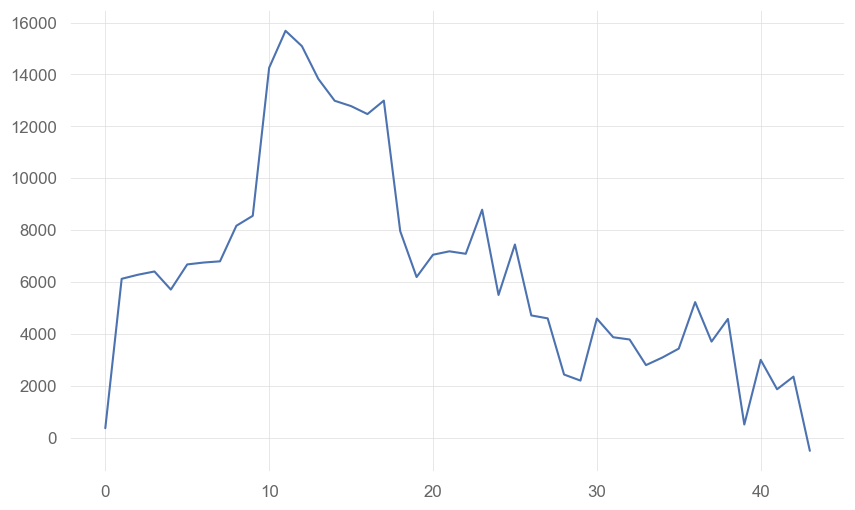

In [57]:
## Simple line plots seem to be using matplotlib
pf_2_bb_custom.trades.records_readable.PnL.cumsum().plot()

In [58]:
pf_2_bb_custom.positions.records_readable

,Position Id,Column,Size,Entry Index,Avg Entry Price,Entry Fees,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status
0,0,0,81969.228752,2019-08-29 12:00:00+00:00,1.219970,0.0,2019-09-01 20:00:00+00:00,1.215580,0.0,359.844914,0.003598,Short,Closed
1,1,0,82561.283432,2019-09-01 20:00:00+00:00,1.215580,0.0,2019-11-12 20:00:00+00:00,1.285365,0.0,5761.539164,0.057409,Long,Closed
2,2,0,82561.283432,2019-11-12 20:00:00+00:00,1.285365,0.0,2019-11-13 12:00:00+00:00,1.283450,0.0,158.104858,0.001490,Short,Closed
3,3,0,82807.658215,2019-11-13 12:00:00+00:00,1.283450,0.0,2019-11-13 20:00:00+00:00,1.284950,0.0,124.211487,0.001169,Long,Closed
4,4,0,82807.658215,2019-11-13 20:00:00+00:00,1.284950,0.0,2019-11-29 12:00:00+00:00,1.293370,0.0,-697.240482,-0.006553,Short,Closed
5,5,0,81729.481851,2019-11-29 12:00:00+00:00,1.293370,0.0,2020-01-21 20:00:00+00:00,1.305230,0.0,969.311655,0.009170,Long,Closed
6,6,0,81729.481851,2020-01-21 20:00:00+00:00,1.305230,0.0,2020-02-05 04:00:00+00:00,1.304335,0.0,73.147886,0.000686,Short,Closed
7,7,0,81841.643046,2020-02-05 04:00:00+00:00,1.304335,0.0,2020-02-05 08:00:00+00:00,1.304900,0.0,46.240528,0.000433,Long,Closed
8,8,0,81841.643046,2020-02-05 08:00:00+00:00,1.304900,0.0,2020-02-28 00:00:00+00:00,1.288145,0.0,1371.256729,0.012840,Short,Closed
9,9,0,83970.683999,2020-02-28 00:00:00+00:00,1.288145,0.0,2020-03-11 08:00:00+00:00,1.292720,0.0,384.165879,0.003552,Long,Closed


In [59]:
pf_2_bb_custom.trades.records_readable

,Exit Trade Id,Column,Size,Entry Index,Avg Entry Price,Entry Fees,Exit Index,Avg Exit Price,Exit Fees,PnL,Return,Direction,Status,Position Id
0,0,0,81969.228752,2019-08-29 12:00:00+00:00,1.219970,0.0,2019-09-01 20:00:00+00:00,1.215580,0.0,359.844914,0.003598,Short,Closed,0
1,1,0,82561.283432,2019-09-01 20:00:00+00:00,1.215580,0.0,2019-11-12 20:00:00+00:00,1.285365,0.0,5761.539164,0.057409,Long,Closed,1
2,2,0,82561.283432,2019-11-12 20:00:00+00:00,1.285365,0.0,2019-11-13 12:00:00+00:00,1.283450,0.0,158.104858,0.001490,Short,Closed,2
3,3,0,82807.658215,2019-11-13 12:00:00+00:00,1.283450,0.0,2019-11-13 20:00:00+00:00,1.284950,0.0,124.211487,0.001169,Long,Closed,3
4,4,0,82807.658215,2019-11-13 20:00:00+00:00,1.284950,0.0,2019-11-29 12:00:00+00:00,1.293370,0.0,-697.240482,-0.006553,Short,Closed,4
5,5,0,81729.481851,2019-11-29 12:00:00+00:00,1.293370,0.0,2020-01-21 20:00:00+00:00,1.305230,0.0,969.311655,0.009170,Long,Closed,5
6,6,0,81729.481851,2020-01-21 20:00:00+00:00,1.305230,0.0,2020-02-05 04:00:00+00:00,1.304335,0.0,73.147886,0.000686,Short,Closed,6
7,7,0,81841.643046,2020-02-05 04:00:00+00:00,1.304335,0.0,2020-02-05 08:00:00+00:00,1.304900,0.0,46.240528,0.000433,Long,Closed,7
8,8,0,81841.643046,2020-02-05 08:00:00+00:00,1.304900,0.0,2020-02-28 00:00:00+00:00,1.288145,0.0,1371.256729,0.012840,Short,Closed,8
9,9,0,83970.683999,2020-02-28 00:00:00+00:00,1.288145,0.0,2020-03-11 08:00:00+00:00,1.292720,0.0,384.165879,0.003552,Long,Closed,9


In [60]:
pnl_series = pf_2_bb_custom.trades.pnl.to_pd()
pnl_series[pnl_series.notna()]

time
2019-09-01 20:00:00+00:00     359.844914
2019-11-12 20:00:00+00:00    5761.539164
2019-11-13 12:00:00+00:00     158.104858
2019-11-13 20:00:00+00:00     124.211487
2019-11-29 12:00:00+00:00    -697.240482
2020-01-21 20:00:00+00:00     969.311655
2020-02-05 04:00:00+00:00      73.147886
2020-02-05 08:00:00+00:00      46.240528
2020-02-28 00:00:00+00:00    1371.256729
2020-03-11 08:00:00+00:00     384.165879
2020-03-16 16:00:00+00:00    5709.166805
2020-04-01 16:00:00+00:00    1425.063216
2020-04-10 00:00:00+00:00    -591.482867
2020-04-23 00:00:00+00:00   -1261.890048
2020-04-27 12:00:00+00:00    -844.030372
2020-05-08 00:00:00+00:00    -206.081785
2020-05-08 12:00:00+00:00    -307.530434
2020-07-06 12:00:00+00:00     518.962960
2020-08-12 12:00:00+00:00   -5034.438409
2020-09-11 08:00:00+00:00   -1769.638940
2020-09-24 04:00:00+00:00     860.815948
2020-09-24 12:00:00+00:00     131.653575
2020-09-24 20:00:00+00:00     -94.639151
2020-10-20 12:00:00+00:00    1699.239417
2020-11-24 

In [61]:
signal = mtf_df['signal'].copy()
signal.loc[clean_long_entries] = 2
signal.loc[clean_long_exits] = 1
signal.loc[clean_short_entries] = -2
signal.loc[clean_short_exits] = -1

In [62]:
mtf_df.signal[mtf_df['signal'] != 0]

time
2019-08-29 12:00:00+00:00   -1
2019-09-01 20:00:00+00:00    1
2019-09-06 04:00:00+00:00    1
2019-09-11 20:00:00+00:00    1
2019-10-04 12:00:00+00:00    1
                            ..
2022-05-12 16:00:00+00:00   -1
2022-06-21 12:00:00+00:00    1
2022-06-30 04:00:00+00:00   -1
2022-07-13 12:00:00+00:00   -1
2022-08-09 00:00:00+00:00    1
Name: signal, Length: 87, dtype: int64

In [63]:
signal[signal != 0]

time
2019-08-29 12:00:00+00:00   -2
2019-09-01 20:00:00+00:00   -1
2019-09-06 04:00:00+00:00    1
2019-09-11 20:00:00+00:00    1
2019-10-04 12:00:00+00:00    1
                            ..
2022-05-12 16:00:00+00:00   -1
2022-06-21 12:00:00+00:00   -1
2022-06-30 04:00:00+00:00   -2
2022-07-13 12:00:00+00:00   -1
2022-08-09 00:00:00+00:00   -1
Name: signal, Length: 87, dtype: int64

In [64]:
mtf_df['cleaned_signal'] = signal

In [65]:
mtf_df["signal"].equals(mtf_df['cleaned_signal'])

False

In [66]:
mtf_df["pnl"] = pnl_series
mtf_df

,m5_close,m5_rsi,m5_bband_price_upper,m5_bband_price_middle,m5_bband_price_lower,m5_bband_rsi_upper,m5_bband_rsi_middle,m5_bband_rsi_lower,m30_close,m30_rsi,...,h4_open,h4_low,h4_high,long_entry,long_exit,signal,short_entries,short_exits,cleaned_signal,pnl
time,,,,,,,,,,,,,,,,,,,,,
2019-08-27 00:00:00+00:00,1.221300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.221705,NaN,...,NaN,NaN,NaN,False,False,0,False,False,0,NaN
2019-08-27 00:05:00+00:00,1.221280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,0,False,False,0,NaN
2019-08-27 00:10:00+00:00,1.221165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,0,False,False,0,NaN
2019-08-27 00:15:00+00:00,1.221145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,0,False,False,0,NaN
2019-08-27 00:20:00+00:00,1.221595,NaN,1.221619,1.221297,1.220975,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,0,False,False,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-26 16:35:00+00:00,1.173785,40.177989,1.174308,1.173867,1.173426,45.681371,40.345471,35.009572,NaN,NaN,...,1.17749,1.17354,1.17836,False,False,0,False,False,0,NaN
2022-08-26 16:40:00+00:00,1.173915,41.774054,1.174169,1.173954,1.173739,43.384374,41.640093,39.895813,NaN,NaN,...,1.17749,1.17354,1.17836,False,False,0,False,False,0,NaN
2022-08-26 16:45:00+00:00,1.173885,41.505727,1.174141,1.173929,1.173717,43.325590,41.585151,39.844713,NaN,NaN,...,1.17749,1.17354,1.17836,False,False,0,False,False,0,NaN


In [67]:
mtf_df.to_csv("2BB_Final_Simulation.csv", index = False)

In [68]:
mtf_df.columns

Index(['m5_close', 'm5_rsi', 'm5_bband_price_upper', 'm5_bband_price_middle',
       'm5_bband_price_lower', 'm5_bband_rsi_upper', 'm5_bband_rsi_middle',
       'm5_bband_rsi_lower', 'm30_close', 'm30_rsi', 'm30_bband_price_upper',
       'm30_bband_price_middle', 'm30_bband_price_lower',
       'm30_bband_rsi_upper', 'm30_bband_rsi_middle', 'm30_bband_rsi_lower',
       'h1_close', 'h1_rsi', 'h1_bband_price_upper', 'h1_bband_price_middle',
       'h1_bband_price_lower', 'h1_bband_rsi_upper', 'h1_bband_rsi_middle',
       'h1_bband_rsi_lower', 'h4_close', 'h4_rsi', 'h4_bband_price_upper',
       'h4_bband_price_middle', 'h4_bband_price_lower', 'h4_bband_rsi_upper',
       'h4_bband_rsi_middle', 'h4_bband_rsi_lower', 'h1_open', 'h1_low',
       'h1_high', 'h4_open', 'h4_low', 'h4_high', 'long_entry', 'long_exit',
       'signal', 'short_entries', 'short_exits', 'cleaned_signal', 'pnl'],
      dtype='object')

**TODO**
* Can we add dotted lines in the plot to connect an entry and exit of a trade order?
* How to access floating equity and balance after the simulation or it the same as `PnL`?
* What other type of order analytics can we do to make this notebook more complete / informative?